2
3
4
5
6
7
8
epoch:   0 seq:   0
epoch:   0 loss: 0.0083347773
epoch:   1 seq:   0
epoch:   1 loss: 0.0069756890
epoch:   2 seq:   0
epoch:   2 loss: 0.0043895636
epoch:   3 seq:   0
epoch:   3 loss: 0.0028169320
epoch:   4 seq:   0
epoch:   4 loss: 0.0017974873
epoch:   5 seq:   0
epoch:   5 loss: 0.0009786722
epoch:   6 seq:   0
epoch:   6 loss: 0.0004061933
epoch:   7 seq:   0
epoch:   7 loss: 0.0001103216
epoch:   8 seq:   0
epoch:   8 loss: 0.0000091038
epoch:   9 seq:   0
epoch:   9 loss: 0.0000059233
epoch:  10 seq:   0
epoch:  10 loss: 0.0000394040
epoch:  11 seq:   0
epoch:  11 loss: 0.0000799574
epoch:  12 seq:   0
epoch:  12 loss: 0.0001160371
epoch:  13 seq:   0
epoch:  13 loss: 0.0001447339
epoch:  14 seq:   0
epoch:  14 loss: 0.0001668500
epoch:  15 seq:   0
epoch:  15 loss: 0.0001846114
epoch:  16 seq:   0
epoch:  16 loss: 0.0002005961
epoch:  17 seq:   0
epoch:  17 loss: 0.0002172076
epoch:  18 seq:   0
epoch:  18 loss: 0.0002363655
epoch:  19 seq:   0
epoch:  19 loss:

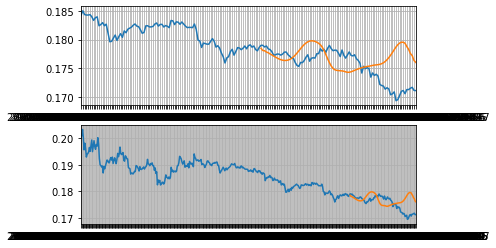

7
8
epoch:   0 seq:   0
epoch:   0 loss: 0.0074624526
epoch:   1 seq:   0
epoch:   1 loss: 0.0048858649
epoch:   2 seq:   0
epoch:   2 loss: 0.0025186206
epoch:   3 seq:   0
epoch:   3 loss: 0.0021748261
epoch:   4 seq:   0
epoch:   4 loss: 0.0014483783
epoch:   5 seq:   0
epoch:   5 loss: 0.0006058860
epoch:   6 seq:   0
epoch:   6 loss: 0.0001802656
epoch:   7 seq:   0
epoch:   7 loss: 0.0000408379
epoch:   8 seq:   0
epoch:   8 loss: 0.0000067560
epoch:   9 seq:   0
epoch:   9 loss: 0.0000009871
epoch:  10 seq:   0
epoch:  10 loss: 0.0000006885
epoch:  11 seq:   0
epoch:  11 loss: 0.0000025882
epoch:  12 seq:   0
epoch:  12 loss: 0.0000087484
epoch:  13 seq:   0
epoch:  13 loss: 0.0000207153
epoch:  14 seq:   0
epoch:  14 loss: 0.0000371308
epoch:  15 seq:   0
epoch:  15 loss: 0.0000542387
epoch:  16 seq:   0
epoch:  16 loss: 0.0000680939
epoch:  17 seq:   0
epoch:  17 loss: 0.0000762024
epoch:  18 seq:   0
epoch:  18 loss: 0.0000778271
epoch:  19 seq:   0
epoch:  19 loss: 0.0000734

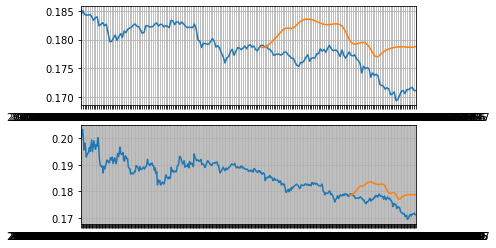

KeyboardInterrupt: 

In [1]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]

# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 6
print('6')
for train_window in [110, 120]:

    train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

    # 7
    print('7')


    class LSTM(nn.Module):
        def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
            super().__init__()
            self.hidden_layer_size = hidden_layer_size

            self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

            self.linear = nn.Linear(hidden_layer_size, output_size)

            self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                                torch.zeros(1, 1, self.hidden_layer_size).to(device))

        def forward(self, input_seq):
            lstm_out, self.hidden_cell = self.lstm(
                input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
            predictions = self.linear(lstm_out.view(len(input_seq), -1))
            return predictions[-1]

    model = LSTM().to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # Learn rate will likely be in [0.0001, 0.01]

    start = time.time()

    training_loss = []

    # 8
    print('8')
    epochs = 1500
    for i in range(epochs):
        j = 0
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                          torch.zeros(1, 1, model.hidden_layer_size).to(device))
            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
            training_loss.append(single_loss.item())
            if j % 1000 == 0:
                print(f'epoch: {i:3} seq: {j:3}')
            j += 1
            # print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

    end = time.time()
    print('Time Elapsed')
    print(end-start)

    # 9
    print('9')
    fut_pred = test_data_size

    test_inputs = train_data_normalized[-train_window:].tolist()
    print(test_inputs)

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:]).to(device)
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                            torch.zeros(1, 1, model.hidden_layer_size).to(device))
            test_inputs.append(model(seq).item())

    print(test_inputs[fut_pred:])

    actual_predictions = scaler.inverse_transform(
        np.array(test_inputs[train_window:]).reshape(-1, 1))
    print(actual_predictions)


    figure, axis = plt.subplots(2, 1)

    axis[0].grid(True)
    axis[0].autoscale(axis='x', tight=True)
    axis[0].plot(df['Time'][-(fut_pred + 100):],
                df['ask_price'][-(fut_pred + 100):])
    axis[0].plot(df['Time'][-fut_pred:], actual_predictions)
    axis[1].grid(True)
    axis[1].autoscale(axis='x', tight=True)
    axis[1].plot(df['Time'], df['ask_price'])
    axis[1].plot(df['Time'][-fut_pred:], actual_predictions)
    plt.show()

In [2]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]

# 2

In [3]:
df

,ask_price,bid_price,mark_price,high_price,low_price,open_price,volume,Time
0,0.200270,0.199350,0.199810,0.215235,0.18706,0.189590,0.0,2022-01-14 00:00:04.902853
500,0.201190,0.200200,0.200695,0.215235,0.18706,0.189590,0.0,2022-01-14 00:09:55.193652
1000,0.203410,0.202429,0.202919,0.215235,0.18706,0.189590,0.0,2022-01-14 00:19:46.144906
1500,0.200480,0.199481,0.199980,0.215235,0.18706,0.189590,0.0,2022-01-14 00:29:36.625367
2000,0.195680,0.194735,0.195207,0.215235,0.18706,0.189590,0.0,2022-01-14 00:39:28.082535
...,...,...,...,...,...,...,...,...
217000,0.171340,0.170557,0.170948,0.171680,0.16878,0.169965,0.0,2022-01-16 23:12:28.559411
217500,0.171574,0.170759,0.171166,0.171680,0.16878,0.169965,0.0,2022-01-16 23:22:18.374566
218000,0.171730,0.170910,0.171320,0.171680,0.16878,0.169965,0.0,2022-01-16 23:32:07.688576
218500,0.171190,0.170310,0.170750,0.171680,0.16878,0.169965,0.0,2022-01-16 23:41:57.163325


In [4]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# 6
print('6')
for train_window in [110, 120]:

    train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

2
3
4
5
6


In [5]:
train_inout_seq

[(tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
           6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
           3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
           3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
           5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
           2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
          -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
           1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
           1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
           1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
           3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
           3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
           1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
          -2.3047e-01, -2

In [6]:
len(train_inout_seq)

232

In [7]:
train_inout_seq[0]

(tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
          6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
          3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
          3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
          5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
          2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
         -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
          1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
          1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
          1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
          3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
          3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
          1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
         -2.3047e-01, -2.0351e-01, -2.

In [8]:
train_inout_seq[0][0]

tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
         6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
         3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
         3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
         5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
         2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
        -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
         1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
         1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
         1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
         3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
         3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
         1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
        -2.3047e-01, -2.0351e-01, -2.0424e-01, -2.2

In [9]:
train_inout_seq[0][0].size()

torch.Size([120])

In [10]:
a = train_inout_seq[0][0]

In [11]:
a

tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
         6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
         3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
         3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
         5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
         2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
        -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
         1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
         1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
         1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
         3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
         3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
         1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
        -2.3047e-01, -2.0351e-01, -2.0424e-01, -2.2

In [12]:
b = a.reshape(30, -1)

In [13]:
b.shape

torch.Size([30, 4])

In [14]:
b = a.reshape(120, 1, -1)

In [15]:
b.shape

torch.Size([120, 1, 1])

In [16]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), 1, -1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

2
3
4
5


In [17]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), 1, -1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

2
3
4
5


In [18]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), 1, -1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
model = LSTM().to(device)

pred = model(input)

2
3
4
5
input shape:  torch.Size([120])
lstm_out shape:  torch.Size([120, 1, 100])
preds shape:  torch.Size([120, 1])


In [19]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), 1, -1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
model = LSTM().to(device)

pred = model(input)

2
3
4
5
input shape:  torch.Size([120])
lstm_out shape:  torch.Size([120, 1, 100])
post reshape right before linear shape:  torch.Size([120, 100])
preds shape:  torch.Size([120, 1])


In [20]:
preds.shape

NameError: name 'preds' is not defined

In [21]:
pred.shape

torch.Size([1])

In [22]:
input

tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
         6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
         3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
         3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
         5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
         2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
        -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
         1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
         1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
         1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
         3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
         3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
         1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
        -2.3047e-01, -2.0351e-01, -2.0424e-01, -2.2

In [23]:
torch.cat((input, input))

tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
         6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
         3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
         3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
         5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
         2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
        -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
         1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
         1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
         1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
         3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
         3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
         1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
        -2.3047e-01, -2.0351e-01, -2.0424e-01, -2.2

In [24]:
a = torch.cat((input, input))

In [25]:
a.shape

torch.Size([240])

In [26]:
a = torch.cat((input, input), 0)

In [27]:
a.shape

torch.Size([240])

In [28]:
a = torch.cat((input, input), 1)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [29]:
a = torch.cat((input, input)).reshape(120, -1)

In [30]:
a.shape

torch.Size([120, 2])

In [31]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), 1, -1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])


RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 2

In [32]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size).to(device),
                            torch.zeros(1, 1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])


RuntimeError: Expected hidden[0] size (1, 2, 100), got [1, 1, 100]

In [33]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, -1, self.hidden_layer_size).to(device),
                            torch.zeros(1, -1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5


RuntimeError: Trying to create tensor with negative dimension -1: [1, -1, 100]

In [34]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])
lstm_out shape:  torch.Size([120, 2, 100])
post reshape right before linear shape:  torch.Size([120, 200])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (120x200 and 100x1)

In [35]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1, 2, 100]
        print("last out", last_output_lstm.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])
lstm_out shape:  torch.Size([120, 2, 100])


IndexError: index 2 is out of bounds for dimension 1 with size 2

In [36]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]
        print("last out", last_output_lstm.shape)
        print("post reshape right before linear shape: ", lstm_out.view(len(input_seq), -1).shape)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        print("preds shape: ", predictions.shape)

        return predictions[-1]


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])
lstm_out shape:  torch.Size([120, 2, 100])
last out torch.Size([2, 100])
post reshape right before linear shape:  torch.Size([120, 200])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (120x200 and 100x1)

In [37]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]
        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]
a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])
lstm_out shape:  torch.Size([120, 2, 100])
last out torch.Size([2, 100])
preds shape:  torch.Size([2, 1])


In [38]:
input

tensor([ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
         6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
         3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
         3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
         5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
         2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
        -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
         1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
         1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
         1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
         3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
         3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
         1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
        -2.3047e-01, -2.0351e-01, -2.0424e-01, -2.2

In [39]:
torch.tensor([input, input])

ValueError: only one element tensors can be converted to Python scalars

In [40]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
train_data_normalized = torch.FloatTensor(
    train_data_normalized).view(-1).to(device)

2
3
4
5


In [41]:
train_data_normalized.shape

torch.Size([352])

In [42]:
train_data.shape

(352,)

In [43]:
train_data

array([0.20027 , 0.20119 , 0.20341 , 0.20048 , 0.19568 , 0.19822 ,
       0.19621 , 0.19296 , 0.194   , 0.19431 , 0.19493 , 0.1966  ,
       0.19515 , 0.19736 , 0.19941 , 0.195   , 0.19706 , 0.19915 ,
       0.196917, 0.195902, 0.197724, 0.197063, 0.20029 , 0.197838,
       0.19239 , 0.19003 , 0.18973 , 0.18921 , 0.1896  , 0.18695 ,
       0.18942 , 0.18853 , 0.18969 , 0.19068 , 0.19184 , 0.19164 ,
       0.190852, 0.19079 , 0.192   , 0.19278 , 0.191819, 0.19295 ,
       0.19053 , 0.19164 , 0.19268 , 0.19171 , 0.19047 , 0.19217 ,
       0.194363, 0.19308 , 0.19416 , 0.19675 , 0.19434 , 0.19389 ,
       0.19424 , 0.19467 , 0.1917  , 0.1914  , 0.19344 , 0.19305 ,
       0.19231 , 0.19223 , 0.18903 , 0.18873 , 0.18856 , 0.18652 ,
       0.18689 , 0.18688 , 0.18654 , 0.18699 , 0.18753 , 0.18748 ,
       0.18975 , 0.18957 , 0.1891  , 0.18852 , 0.18768 , 0.18932 ,
       0.18839 , 0.18826 , 0.18849 , 0.1889  , 0.189221, 0.18843 ,
       0.18909 , 0.18933 , 0.19006 , 0.192101, 0.19039 , 0.190

In [44]:
a = np.array([1,2,3])

In [45]:
torch.tensor([a, a])

<ipython-input-45-1f1201c9c738>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  torch.tensor([a, a])


tensor([[1, 2, 3],
        [1, 2, 3]])

In [46]:
test = []
for i in range(100):
    test.append(a)

torch.tensor(test)


tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 

In [47]:
test = []
for i in range(100):
    test.append(a)

torch.tensor(test).shape


torch.Size([100, 3])

In [48]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]

a = torch.tensor([input, input])

2
3
4
5


In [49]:
a.shape

torch.Size([2, 120])

In [50]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]

a = torch.tensor([input, input])

# a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([2, 120])


RuntimeError: Expected hidden[0] size (1, 120, 100), got [1, 2, 100]

In [51]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]

a = torch.tensor([input, input]).reshape(120, -1)

# a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])


RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cpu and hidden tensor at cuda:0

In [52]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]

a = torch.tensor([input, input]).to(device).reshape(120, -1)

# a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])


RuntimeError: Input and hidden tensors are not the same dtype, found input tensor with Double and hidden tensor with Float

In [53]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
input = train_inout_seq[0][0]

a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)

# a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(a)

2
3
4
5
input shape:  torch.Size([120, 2])
lstm_out shape:  torch.Size([120, 2, 100])
last out torch.Size([2, 100])
preds shape:  torch.Size([2, 1])


In [54]:
len(train_inout_seq)

232

In [55]:
train_inout_seq[0:2]

[(array([ 7.71245401e-01,  8.38269042e-01,  1.00000000e+00,  7.86544276e-01,
          4.36855717e-01,  6.21899246e-01,  4.75467162e-01,  2.38698867e-01,
          3.14464722e-01,  3.37048774e-01,  3.82216880e-01,  5.03879357e-01,
          3.98244272e-01,  5.59246713e-01,  7.08592868e-01,  3.87316505e-01,
          5.37391178e-01,  6.89651404e-01,  5.26973373e-01,  4.53028813e-01,
          5.85764762e-01,  5.37609733e-01,  7.72702437e-01,  5.94069865e-01,
          1.97173351e-01,  2.52431428e-02,  3.38760791e-03, -3.44953193e-02,
         -6.08312388e-03, -1.99140349e-01, -1.91964448e-02, -8.40345317e-02,
          4.73536590e-04,  7.25968018e-02,  1.57104870e-01,  1.42534514e-01,
          8.51273085e-02,  8.06104979e-02,  1.68761155e-01,  2.25585546e-01,
          1.55574983e-01,  2.37970349e-01,  6.16690343e-02,  1.42534514e-01,
          2.18300368e-01,  1.47634138e-01,  5.72979274e-02,  1.81145959e-01,
          3.40909919e-01,  2.47441081e-01,  3.26121007e-01,  5.14807125e-01,

In [56]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    input_seq = []
    output_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        input_seq.append(train_seq)
        output_seq.append(train_label)
    return input_seq, output_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120

### 
train_input, train_labels = create_inout_sequences(train_data_normalized, train_window)
input = train_input[0] ## 1 x 120

batchsize = 2

train_dataset = []
for i in range(0, len(train_input) - batchsize, batchsize):
    batched_input = train_input[i, i + batchsize]
    torch_batched_input = torch.FloatTensor(batched_input).to(device)

    batcheded_output = train_labels[i, i + batchsize]
    torch_batcheded_output = torch.FloatTensor(batcheded_output).to(device)

    train_dataset.append((torch_batched_input, torch_batcheded_output))

# a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)

2
3
4
5


TypeError: list indices must be integers or slices, not tuple

In [57]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    input_seq = []
    output_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        input_seq.append(train_seq)
        output_seq.append(train_label)
    return input_seq, output_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120

### 
train_input, train_labels = create_inout_sequences(train_data_normalized, train_window)
input = train_input[0] ## 1 x 120

batchsize = 2

train_dataset = []
for i in range(0, len(train_input) - batchsize, batchsize):
    batched_input = train_input[i : i + batchsize]
    torch_batched_input = torch.FloatTensor(batched_input).to(device)

    batcheded_output = train_labels[i : i + batchsize]
    torch_batcheded_output = torch.FloatTensor(batcheded_output).to(device)

    train_dataset.append((torch_batched_input, torch_batcheded_output))

# a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)

2
3
4
5


In [58]:
len(train_dataset)

115

In [59]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    input_seq = []
    output_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        input_seq.append(train_seq)
        output_seq.append(train_label)
    return input_seq, output_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120

### 
train_input, train_labels = create_inout_sequences(train_data_normalized, train_window)
input = train_input[0] ## 1 x 120

batchsize = 2

train_dataset = []
for i in range(0, len(train_input), batchsize):
    batched_input = train_input[i : i + batchsize]
    torch_batched_input = torch.FloatTensor(batched_input).to(device)

    batcheded_output = train_labels[i : i + batchsize]
    torch_batcheded_output = torch.FloatTensor(batcheded_output).to(device)

    train_dataset.append((torch_batched_input, torch_batcheded_output))

# a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)

2
3
4
5


In [60]:

len(train_inout_seq)

232

In [61]:
len(train_dataset)

116

In [62]:
train_dataset[0]

(tensor([[ 7.7125e-01,  8.3827e-01,  1.0000e+00,  7.8654e-01,  4.3686e-01,
           6.2190e-01,  4.7547e-01,  2.3870e-01,  3.1446e-01,  3.3705e-01,
           3.8222e-01,  5.0388e-01,  3.9824e-01,  5.5925e-01,  7.0859e-01,
           3.8732e-01,  5.3739e-01,  6.8965e-01,  5.2697e-01,  4.5303e-01,
           5.8576e-01,  5.3761e-01,  7.7270e-01,  5.9407e-01,  1.9717e-01,
           2.5243e-02,  3.3876e-03, -3.4495e-02, -6.0831e-03, -1.9914e-01,
          -1.9196e-02, -8.4035e-02,  4.7354e-04,  7.2597e-02,  1.5710e-01,
           1.4253e-01,  8.5127e-02,  8.0610e-02,  1.6876e-01,  2.2559e-01,
           1.5557e-01,  2.3797e-01,  6.1669e-02,  1.4253e-01,  2.1830e-01,
           1.4763e-01,  5.7298e-02,  1.8115e-01,  3.4091e-01,  2.4744e-01,
           3.2612e-01,  5.1481e-01,  3.3923e-01,  3.0645e-01,  3.3195e-01,
           3.6328e-01,  1.4691e-01,  1.2505e-01,  2.7367e-01,  2.4526e-01,
           1.9135e-01,  1.8552e-01, -4.7609e-02, -6.9464e-02, -8.1849e-02,
          -2.3047e-01, -2

In [63]:
train_dataset[0][0].shape

torch.Size([2, 120])

In [64]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    input_seq = []
    output_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        input_seq.append(train_seq)
        output_seq.append(train_label)
    return input_seq, output_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions


train_window = 120

### 
train_input, train_labels = create_inout_sequences(train_data_normalized, train_window)
input = train_input[0] ## 1 x 120

batchsize = 2

train_dataset = []
for i in range(0, len(train_input), batchsize):
    batched_input = train_input[i : i + batchsize]
    torch_batched_input = torch.FloatTensor(batched_input).to(device)
    ## TRANSPOSING HERE DREW
    torch_batched_input = torch.transpose(torch_batched_input, 0, 1)

    batcheded_output = train_labels[i : i + batchsize]
    torch_batcheded_output = torch.FloatTensor(batcheded_output).to(device)

    train_dataset.append((torch_batched_input, torch_batcheded_output))

# a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)

2
3
4
5


In [65]:
train_dataset[0][0].shape

torch.Size([120, 2])

In [66]:
train_dataset[0]

(tensor([[ 7.7125e-01,  8.3827e-01],
         [ 8.3827e-01,  1.0000e+00],
         [ 1.0000e+00,  7.8654e-01],
         [ 7.8654e-01,  4.3686e-01],
         [ 4.3686e-01,  6.2190e-01],
         [ 6.2190e-01,  4.7547e-01],
         [ 4.7547e-01,  2.3870e-01],
         [ 2.3870e-01,  3.1446e-01],
         [ 3.1446e-01,  3.3705e-01],
         [ 3.3705e-01,  3.8222e-01],
         [ 3.8222e-01,  5.0388e-01],
         [ 5.0388e-01,  3.9824e-01],
         [ 3.9824e-01,  5.5925e-01],
         [ 5.5925e-01,  7.0859e-01],
         [ 7.0859e-01,  3.8732e-01],
         [ 3.8732e-01,  5.3739e-01],
         [ 5.3739e-01,  6.8965e-01],
         [ 6.8965e-01,  5.2697e-01],
         [ 5.2697e-01,  4.5303e-01],
         [ 4.5303e-01,  5.8576e-01],
         [ 5.8576e-01,  5.3761e-01],
         [ 5.3761e-01,  7.7270e-01],
         [ 7.7270e-01,  5.9407e-01],
         [ 5.9407e-01,  1.9717e-01],
         [ 1.9717e-01,  2.5243e-02],
         [ 2.5243e-02,  3.3876e-03],
         [ 3.3876e-03, -3.4495e-02],
 

In [8]:
import time
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1
df = pd.read_csv("TestData/file.csv", names=['ask_price', 'bid_price',
                 'mark_price', 'high_price', 'low_price', 'open_price', 'volume', 'Time'])
df = df.iloc[::500]



In [28]:
# 2
print('2')
all_data = df['ask_price'].values.astype(float)

# 3
print('3')
test_data_size = int(len(df.index) * 0.2)
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

# 4
print('4')
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

# 5
print('5')
#train_data_normalized = torch.FloatTensor(
 #   train_data_normalized).view(-1).to(device)

train_data_normalized = train_data_normalized.reshape(-1)


def create_inout_sequences(input_data, tw):
    input_seq = []
    output_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        input_seq.append(train_seq)
        output_seq.append(train_label)
    return input_seq, output_seq



class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size).to(device)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1, 2, self.hidden_layer_size).to(device),
                            torch.zeros(1, 2, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        print("input shape: ", input_seq.shape)
        lstm_out, self.hidden_cell = self.lstm( input_seq.view(len(input_seq), -1, 1), self.hidden_cell )
        print("lstm_out shape: ", lstm_out.shape)
        last_output_lstm = lstm_out[-1]

        print("last out", last_output_lstm.shape)
        # print("post reshape right before linear shape: ", last_output_lstm.view(len(input_seq), -1).shape)
        predictions = self.linear(last_output_lstm)
        print("preds shape: ", predictions.shape)

        return predictions



2
3
4
5


In [39]:


train_window = 120
#train_input array of nparray[120]
#train_labels array of nparray[1]
#batched_input array[2] of nparray[120]
#torch_batched_input torch[2,120]



### 
train_input, train_labels = create_inout_sequences(train_data_normalized, train_window)
input = train_input[0] ## 1 x 120

batchsize = 2

train_dataset = []
for i in range(0, len(train_input), batchsize):
    batched_input = train_input[i : i + batchsize]
    print(batched_input)
    torch_batched_input = torch.FloatTensor(batched_input).to(device)
    print(torch_batched_input)
    ## TRANSPOSING HERE DREW
    torch_batched_input = torch.transpose(torch_batched_input, 0, 1)
    print(torch_batched_input.size())
    print(torch_batched_input)

    batched_output = train_labels[i : i + batchsize]
    print(batched_output)
    torch_batched_output = torch.FloatTensor(batched_output).to(device)
    print(torch_batched_output)

    train_dataset.append((torch_batched_input, torch_batched_output))

# a = torch.FloatTensor([input, input]).to(device).reshape(120, -1)



# a = torch.cat((input, input)).reshape(120, -1)
model = LSTM().to(device)

pred = model(train_dataset[0][0])

[array([ 7.71245401e-01,  8.38269042e-01,  1.00000000e+00,  7.86544276e-01,
        4.36855717e-01,  6.21899246e-01,  4.75467162e-01,  2.38698867e-01,
        3.14464722e-01,  3.37048774e-01,  3.82216880e-01,  5.03879357e-01,
        3.98244272e-01,  5.59246713e-01,  7.08592868e-01,  3.87316505e-01,
        5.37391178e-01,  6.89651404e-01,  5.26973373e-01,  4.53028813e-01,
        5.85764762e-01,  5.37609733e-01,  7.72702437e-01,  5.94069865e-01,
        1.97173351e-01,  2.52431428e-02,  3.38760791e-03, -3.44953193e-02,
       -6.08312388e-03, -1.99140349e-01, -1.91964448e-02, -8.40345317e-02,
        4.73536590e-04,  7.25968018e-02,  1.57104870e-01,  1.42534514e-01,
        8.51273085e-02,  8.06104979e-02,  1.68761155e-01,  2.25585546e-01,
        1.55574983e-01,  2.37970349e-01,  6.16690343e-02,  1.42534514e-01,
        2.18300368e-01,  1.47634138e-01,  5.72979274e-02,  1.81145959e-01,
        3.40909919e-01,  2.47441081e-01,  3.26121007e-01,  5.14807125e-01,
        3.39234328e-01, 

In [43]:
train_dataset

[(tensor([[ 7.7125e-01,  8.3827e-01],
          [ 8.3827e-01,  1.0000e+00],
          [ 1.0000e+00,  7.8654e-01],
          [ 7.8654e-01,  4.3686e-01],
          [ 4.3686e-01,  6.2190e-01],
          [ 6.2190e-01,  4.7547e-01],
          [ 4.7547e-01,  2.3870e-01],
          [ 2.3870e-01,  3.1446e-01],
          [ 3.1446e-01,  3.3705e-01],
          [ 3.3705e-01,  3.8222e-01],
          [ 3.8222e-01,  5.0388e-01],
          [ 5.0388e-01,  3.9824e-01],
          [ 3.9824e-01,  5.5925e-01],
          [ 5.5925e-01,  7.0859e-01],
          [ 7.0859e-01,  3.8732e-01],
          [ 3.8732e-01,  5.3739e-01],
          [ 5.3739e-01,  6.8965e-01],
          [ 6.8965e-01,  5.2697e-01],
          [ 5.2697e-01,  4.5303e-01],
          [ 4.5303e-01,  5.8576e-01],
          [ 5.8576e-01,  5.3761e-01],
          [ 5.3761e-01,  7.7270e-01],
          [ 7.7270e-01,  5.9407e-01],
          [ 5.9407e-01,  1.9717e-01],
          [ 1.9717e-01,  2.5243e-02],
          [ 2.5243e-02,  3.3876e-03],
          [ 